# Why overdue tasks take still a long time to finish?

The prototypical situation that has been puzzling me for a while is the following:  
_- We estimated 3 days for a task  
- Bob has been working on the task for 3 days already  
- On the daily scrum, he says that he just needs to take care of a couple more things and the task will be finished  
- The task is not finished the next day_

Sometimes such tasks are not finished even after 5 days of work. Since they are typically “more research-less development” tasks, many people suggest accepting this kind of uncertainty as inherent to research. While I agree to a point, I don’t want to give up predictability so easily. A year ago, Erik Bernhardsson shared a [fascinating blog post on time estimations](https://erikbern.com/2019/04/15/why-software-projects-take-longer-than-you-think-a-statistical-model.html), concluding that the reason why development tasks take longer than expected is that the blowup factor (actual time/expected time) follows a lognormal distribution and our estimates are accurate for the Median but not so much for the Mean task completion time. I really liked his post and re-read it several times last year because it finally helped me to understand why is it so difficult to play scrum poker. I’m taking his model as the basis for my work here, to see if we need to finetune our estimate for task completion.

#### Estimates are smaller than expected finishing times

When in the above example, Bob was 3 days into the task, it was intuitive to believe that he was really about to finish it. After all, the estimated time need for the task was 3 days. However, statistically speaking, our estimate of 3 days was an estimate for the Median of the underlying distribution. The Median of the distribution does not say too much about the scale of the values, it just says plain and simple that 50% of the time the task would be completed faster, and 50% of the time it would take longer than 3 days. A problem with the Median is that it is **not** sensitive to the uncertainty in the task. However, when you want to calculate the development time of a feature, you do want to take into account the uncertainty. Therefore, it is better to calculate the expected value for the task completion time for which we have pretty much all the information we need. Let’s see what this expected value would look like.

The expected value for the lognormal distribution is:

$$ \operatorname{E} = \exp(\mu + \frac{\sigma^2}{2}) $$

To calculate this, we need to know two parameters μ and σ. Luckily, we have an unbiased estimate for the Median, and since that is:

$$ Median = \exp(\mu) $$

We have μ already. For σ, the case is a bit more tricky but not hopeless. Erik’s idea was to use the gut feeling of risk. My proposal, in addition, is to use the spread of the scrum poker estimates as an uncalibrated estimate for σ. To be sure, this is an uncalibrated estimate because — although it should be correlated with some sort of uncertainty — it still doesn’t reflect any particular scaling factor. Probably, this is also team and environment-dependent, so it’s best to estimate it based on the actual data collected from the sprints. Basically, you need the individual estimates and the actual time to be able to fit a simple model and get σ for your team. One addition: likely, the uncertainty around a task can be better estimated with a model that also factors in who the assignee is (no offence meant to anyone ;). Some people are better at streamlining, while others are much more conscious of details.

#### The Bermuda triangle of the “Doing” column

So let’s get back to the daily scrum where Bob said that he was about to finish the task that we estimated to take 3 days of work (just as a remark, Bob is a fictive person). The question is whether we should just accept that the mean completion time is bigger than our estimate (Median) anyway, or if there is more to this story than meets the eye.

Let’s say when we did the scrum poker we voted as follows: Me: 2; John: 2, Bob: 3, Sarah: 3, Linda: 5, Mary: 5. Based on this we had an estimate of 3 days. Now the three days passed, so the question is whether we should still stick to the same estimate? Actually, it turned out that both John and I were wrong in gauging the difficulty of the task, so one can already see intuitively that the Median of the remaining votes (discounting our lousy votes) can be considered to be higher (it is now 4 days!). More generally speaking, when we made our estimate before the task was started we took into account all kinds of outcomes, amongst them the case when the task could have been completed in a few minutes (perhaps if Bob had realized that the same feature already existed someplace but with a different name), to the absurd case of a very difficult implementation process (perhaps if the feature had been more complicated than we imagined). Statistically, we calculate the expected value by integrating over the entire distribution. Now for any time point _t_ > 0 it is evident that we can’t consider times between 0 and _t_ in the integration and have to instead calculate the expected value as follows:

$$ \operatorname{E}[X] = \int_{t}^{\infty} x f(x)\, dx. $$

Where _f(x)_ is the conditional probability of _x_ given that we consider points from _t_ to _∞_. So we are not considering the cases which we already know did not materialize and are considering only cases when the task will take at least a time of _t_ to be completed.

So although beyond the peak of the distribution, points right after _t_ have a relatively higher probability than points farther away, there are much more points farther away and the curvature is also changing as it moves away from the peak, so the expected value is actually blowing up. Let’s demonstrate this through an example. Let’s take three cases to illustrate, (1) where the task is in “todo” phase and we have not started it yet, (2) where the task has already been worked on for the initially estimated time (blowup factor of 1), and (3) where the task has been worked on for double the initially estimated time (blowup factor of 2).

Populating the interactive namespace from numpy and matplotlib


Text(0, 0.5, 'Probability distribution')

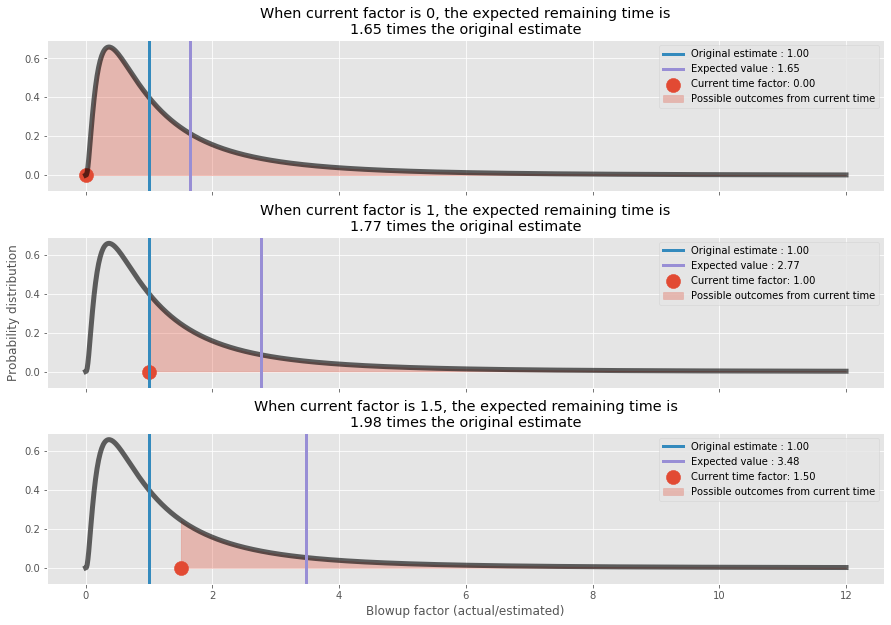

In [1]:
%pylab inline
from scipy.stats import lognorm, rv_continuous
matplotlib.style.use('ggplot')

# parameters of the distribution of the blowup factor

mu = 0  # given that the median is an unbiased estimate of the actual time
sigma = 1  # the uncertainty

# statistics of the distribution

theoretic_median = exp(mu)
theoretic_exp_val = exp(mu + sigma ** 2 / 2)

# samples from the distribution

x = np.linspace(0, 12, 1000)
y = lognorm.pdf(x, s=sigma, scale=exp(mu))

# testing

integrated_exp_val = rv_continuous.expect(lognorm, args=(sigma, ),
        lb=0, ub=inf, conditional=True)
np.testing.assert_approx_equal(integrated_exp_val, theoretic_exp_val)
already_started_task_exp_val = rv_continuous.expect(lognorm,
        args=(sigma, ), lb=0.001, ub=inf, conditional=True)
assert already_started_task_exp_val > integrated_exp_val, \
    'we expect that the E for a task in process is higher than when it was in to do'

# ploting

(fig, axs) = plt.subplots(3, sharex=True, sharey=True,
                          gridspec_kw={'hspace': 0.3}, figsize=(15, 10))

for (i, time_spent) in enumerate([0, 1, 1.5]):
    x_fill = np.linspace(time_spent, 12, 1000)
    y_fill = lognorm.pdf(x_fill, s=sigma, scale=exp(mu))
    exp_val = rv_continuous.expect(lognorm, args=(sigma, ),
                                   lb=time_spent, ub=inf,
                                   conditional=True)

    axs[i].scatter(time_spent, 0, s=200,
                   label='Current time factor: %.2f' % time_spent)
    axs[i].plot(x, y, 'k-', lw=5, alpha=0.6)
    axs[i].fill_between(
        x_fill,
        y_fill * 0,
        y_fill,
        color='C0',
        alpha=0.3,
        label='Possible outcomes from current time',
        )
    axs[i].axvline(x=theoretic_median, color='C1', lw=3,
                   label='Original estimate : %.2f' % theoretic_median)
    axs[i].axvline(x=exp_val, color='C2', lw=3,
                   label='Expected value : %.2f' % exp_val)
    axs[i].legend()
    axs[i].set_title('When current factor is {0}, the expected remaining time is\n{1:0.2f} times the original estimate'.format(
                     time_spent,
                     exp_val - time_spent))

# aesthetics

axs[2].set_xlabel('Blowup factor (actual/estimated)')
axs[1].set_ylabel('Probability distribution')

Now you see a paradoxical thing: the remaining time, operationalized by E_t — t, is not shrinking as we proceed but it is growing. This, of course, does not mean that we cannot finish tasks; it just helps to make increasingly better estimates for the remaining work by factoring the elapsed time into the equation. We can use this knowledge in multiple scenarios. First, it can help teams make better decisions on when to cut or restructure tasks, and in general to understand when they’re like to be finished (i.e. as a rule of thumb reject the notion of finishing in the next hour when the blowup factor is already 2).

Second, this knowledge is also critical to recognize tasks that are becoming impossible to finish in time. We have seen several tasks, which seemed tractable at first sight and then became the bogeyman of the project. It is essential to detect these as early as possible and rethink deliverables, handle expectations, and/or come up with alternative solutions.

Also, the assumption in this exercise is that during the execution of a task, there are no “feedback effects of inspection”. In reality, the feedback of the team during the daily scrum or of the stakeholders during a review may change the approach (with the distribution) and hence the expected time to finish too. In fact, if you look at the distribution of blowup factors in the [SiP dataset](https://github.com/Derek-Jones/SiP_dataset) (which Erik also looked at) the right tail is not as heavy as one would expect from a standard lognormal distribution, my hypothesis is that it is exactly those feedback, control and restructuring mechanisms — which kick into action when the blowup factor becomes large — that are responsible for this. So, my main suggestion would be for teams to pay close attention to what plays out in the daily scrums to help avoid story completion time blowup.

Code is available on [github](https://github.com/agostontorok/TaskCompletionTimeEstimation)

Remarks:

-   Derek M. Jones put together [an interesting paper](https://arxiv.org/pdf/1901.01621.pdf) based on his analysis of the SiP dataset and an interview with Stephen Cullum, founder of SiP. His analysis also suggests that estimates are not only growing as estimators are becoming more accurate but also decreasing as some task types are repeated more and more.
-   In the SiP dataset estimates were made by single developers and not as a joint effort, also most of the estimates there are in the sub 2 days range.

Thanks for the comments of Adam Csapo on the first draft